# RFM Analysis

This notebook explains how to perform RFM analysis from customer purchase history data. The sample orders file is Sample - Superstore dataset from Tableau Software.
This type of analysis can be done and be leveraged in personalizing marketing communications in orfer to boost sales.

<hr>

<b> Recency </b> - How recent the customer has shopped with us

<b> Frequency </b> - How frequent the customer has shopped with us  (Number of Visits)

<b> Monetary Value </b> - How much the customer has spent with us



# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Reading Sample Orders File

In [2]:
orders = pd.read_csv('sample-orders.csv',sep=',',encoding= 'unicode_escape')

In [3]:
orders.head()

,order_date,order_id,customer,grand_total
0,9/7/11,CA-2011-100006,Dennis Kane,378
1,7/8/11,CA-2011-100090,Ed Braxton,699
2,3/14/11,CA-2011-100293,Neil Franzsisch,91
3,1/29/11,CA-2011-100328,Jasper Cacioppo,4
4,4/8/11,CA-2011-100363,Jim Mitchum,21


# Exploratory Data Analysis

In [4]:
orders.shape

(5009, 4)

In [5]:
orders.isnull().sum()

order_date     0
order_id       0
customer       0
grand_total    0
dtype: int64

In [6]:
print("Total Number of Unique Customers : {}".format(orders['customer'].nunique()))

Total Number of Unique Customers : 793


In [7]:
print("Total Number of Transactions : {}".format(orders['order_id'].nunique()))

Total Number of Transactions : 5009


In [8]:
print("Total Amount of Transactions : {}".format(orders['grand_total'].sum()))

Total Amount of Transactions : 2297261


# Checking Orders Data Range as data might be old

In [9]:
orders['order_date'] = pd.to_datetime(orders['order_date'])

In [10]:
orders['year'] = orders['order_date'].dt.year

In [11]:
orders['year'].value_counts(normalize = True)

2014    0.337792
2013    0.261529
2012    0.207227
2011    0.193452
Name: year, dtype: float64

# Adding 7 years in every order date just to get realistic recency

In [12]:
from datetime import timedelta
orders['order_date'] = orders['order_date'] + timedelta(days = 2555)

In [13]:
orders['year'] = orders['order_date'].dt.year

In [14]:
orders['year'].value_counts(normalize = True)

2021    0.335995
2020    0.263326
2019    0.206828
2018    0.193851
Name: year, dtype: float64

## Creating the RFM Table at customer level

Calculating Recency from current date

Set this date to the current day and extract all orders until yesterday.

In [15]:
import datetime as dt

current_time = dt.datetime.now() 
print(current_time)

NOW = dt.datetime(current_time.year,current_time.month,current_time.day)



2022-04-19 11:47:36.909617


Create the RFM Table

In [16]:
rfmTable = orders.groupby('customer').agg({'order_date': lambda x: (NOW - x.max()).days, # Recency
                                        'order_id': lambda x: len(x),      # Frequency
                                        'grand_total': lambda x: x.sum()}) # Monetary Value

rfmTable['order_date'] = rfmTable['order_date'].astype(int)
rfmTable.rename(columns={'order_date': 'recency', 
                         'order_id': 'frequency', 
                         'grand_total': 'monetary_value'}, inplace=True)

## Validating the RFM Table

In [17]:
rfmTable.head()

,recency,frequency,monetary_value
customer,,,
Aaron Bergman,526,3,887
Aaron Hawkins,123,7,1744
Aaron Smayling,199,7,3050
Adam Bellavance,165,8,7756
Adam Hart,145,10,3249


Customer **Aaron Bergman** has frequency:3, monetary value:$887 and recency:523 days.

In [18]:
aaron = orders[orders['customer']=='Aaron Bergman']
aaron

,order_date,order_id,customer,grand_total,year
624,2018-02-17,CA-2011-152905,Aaron Bergman,13,2018
665,2018-03-05,CA-2011-156587,Aaron Bergman,310,2018
2336,2020-11-09,CA-2013-140935,Aaron Bergman,564,2020


Inserting the date of Aaron purchase and comparing it to the recency in the rfmTable we verify our RFM table is correct.

In [20]:
(NOW - dt.datetime(2020,11,9)).days==526

True

## Determining RFM Quartiles

In [21]:
rfmTable.head()

,recency,frequency,monetary_value
customer,,,
Aaron Bergman,526,3,887
Aaron Hawkins,123,7,1744
Aaron Smayling,199,7,3050
Adam Bellavance,165,8,7756
Adam Hart,145,10,3249


# Visualizing BoxPlots

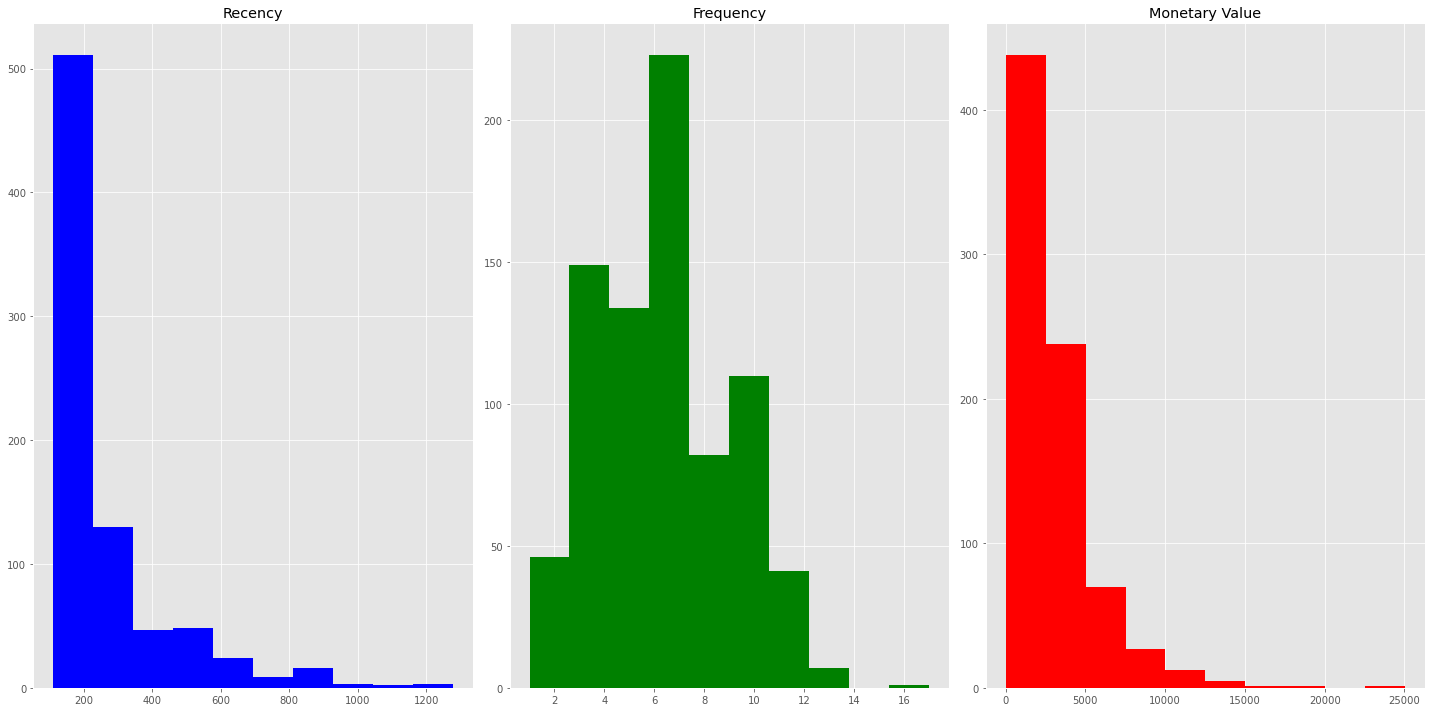

In [22]:
plt.subplot(1,3,1)
plt.hist(rfmTable['recency'],color='blue')
plt.title("Recency")

plt.subplot(1,3,2)
plt.hist(rfmTable['frequency'],color = 'green')
plt.title("Frequency")

plt.subplot(1,3,3)
plt.hist(rfmTable['monetary_value'],color = 'red')
plt.title("Monetary Value")


plt.tight_layout()

## Analysis - 
<ol>
    <li> Recency - There are a lot of customers who haven't visited in more than 2 years - Reactivate them </li>
     <li> Frequency - Majority of the customers have made between 4-14 visits </li>
    <li> Monetary Value - Majority of the customers have sent less than 10,000 with some high spending customers as well </li>

# Quantile Charts

In [23]:
quantiles = rfmTable.quantile(q=[0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

In [24]:
quantiles

,recency,frequency,monetary_value
0.10,123.0,3.0,583.2
0.20,137.0,4.0,961.4
0.25,141.0,5.0,1145.0
0.30,148.0,5.0,1323.2
0.40,164.0,5.0,1739.8
0.50,186.0,6.0,2257.0
0.60,214.0,7.0,2750.8
0.70,258.2,8.0,3282.6
0.80,335.6,8.6,4282.6
0.90,516.8,10.0,6038.6


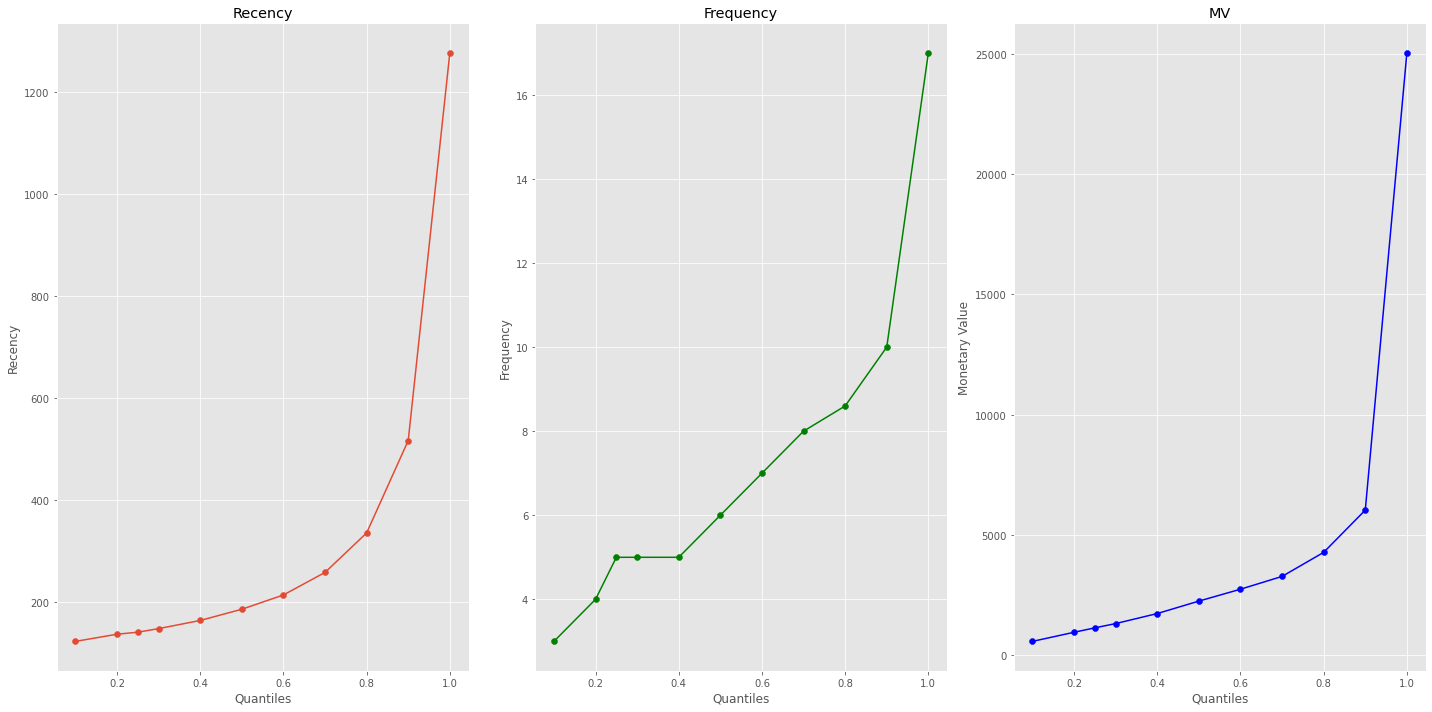

In [25]:
plt.subplot(1,3,1)
plt.plot(quantiles.index,quantiles['recency'])
plt.scatter(quantiles.index,quantiles['recency'])
plt.xlabel("Quantiles")
plt.ylabel("Recency")
plt.title("Recency")

plt.subplot(1,3,2)
plt.plot(quantiles.index,quantiles['frequency'],color = 'green')
plt.scatter(quantiles.index,quantiles['frequency'],color = 'green')
plt.xlabel("Quantiles")
plt.ylabel("Frequency")
plt.title("Frequency")


plt.subplot(1,3,3)
plt.plot(quantiles.index,quantiles['monetary_value'],color = 'blue')
plt.scatter(quantiles.index,quantiles['monetary_value'],color='blue')
plt.xlabel("Quantiles")
plt.ylabel("Monetary Value")
plt.title("MV")

plt.tight_layout()

Send quantiles to a dictionary, easier to use.

In [26]:
quantiles = quantiles.to_dict()

In [27]:
quantiles

{'recency': {0.1: 123.0,
  0.2: 137.0,
  0.25: 141.0,
  0.3: 148.0,
  0.4: 164.0,
  0.5: 186.0,
  0.6: 214.0,
  0.7: 258.19999999999993,
  0.8: 335.6,
  0.9: 516.8000000000001,
  1.0: 1277.0},
 'frequency': {0.1: 3.0,
  0.2: 4.0,
  0.25: 5.0,
  0.3: 5.0,
  0.4: 5.0,
  0.5: 6.0,
  0.6: 7.0,
  0.7: 8.0,
  0.8: 8.600000000000023,
  0.9: 10.0,
  1.0: 17.0},
 'monetary_value': {0.1: 583.2,
  0.2: 961.4,
  0.25: 1145.0,
  0.3: 1323.1999999999998,
  0.4: 1739.8,
  0.5: 2257.0,
  0.6: 2750.8,
  0.7: 3282.6,
  0.8: 4282.6,
  0.9: 6038.600000000004,
  1.0: 25042.0}}

# Creating Segmentation based on Monetary Value (Spend) and Frequency Visits

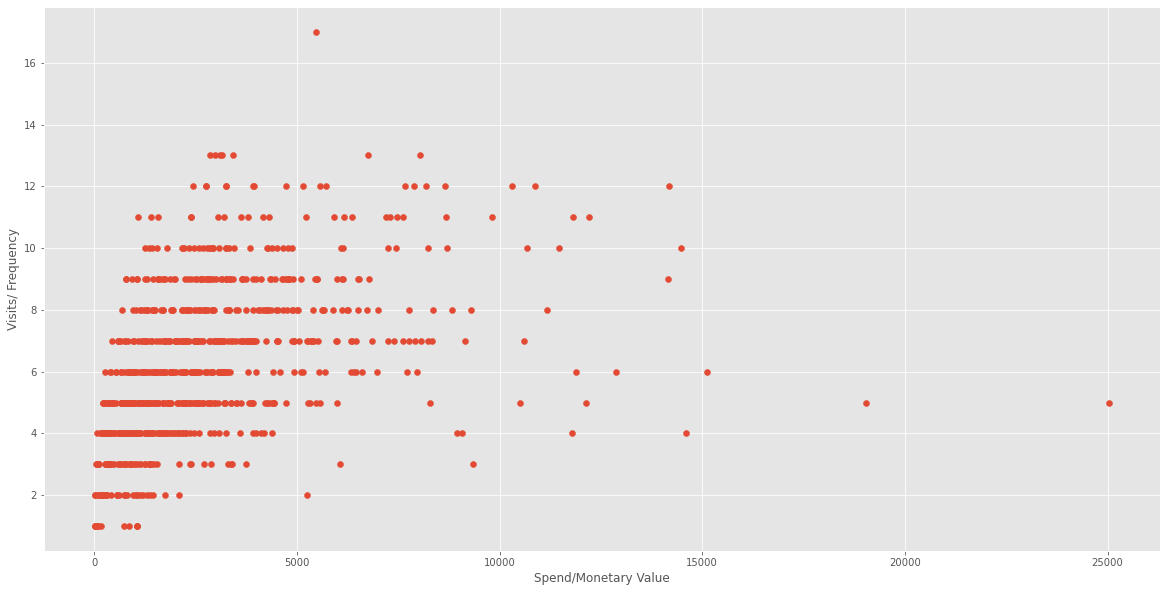

In [28]:
plt.scatter(x = rfmTable['monetary_value'],y = rfmTable['frequency'])
plt.xlabel("Spend/Monetary Value")
plt.ylabel("Visits/ Frequency")
plt.show()

### Rule - 
1. Spend - If a customer has spent more than 60th Quantile the he is a big spender else low spender <br>
2. Visits - If a customer has visits more than 70th Quantile the he is a visitor else low visitor

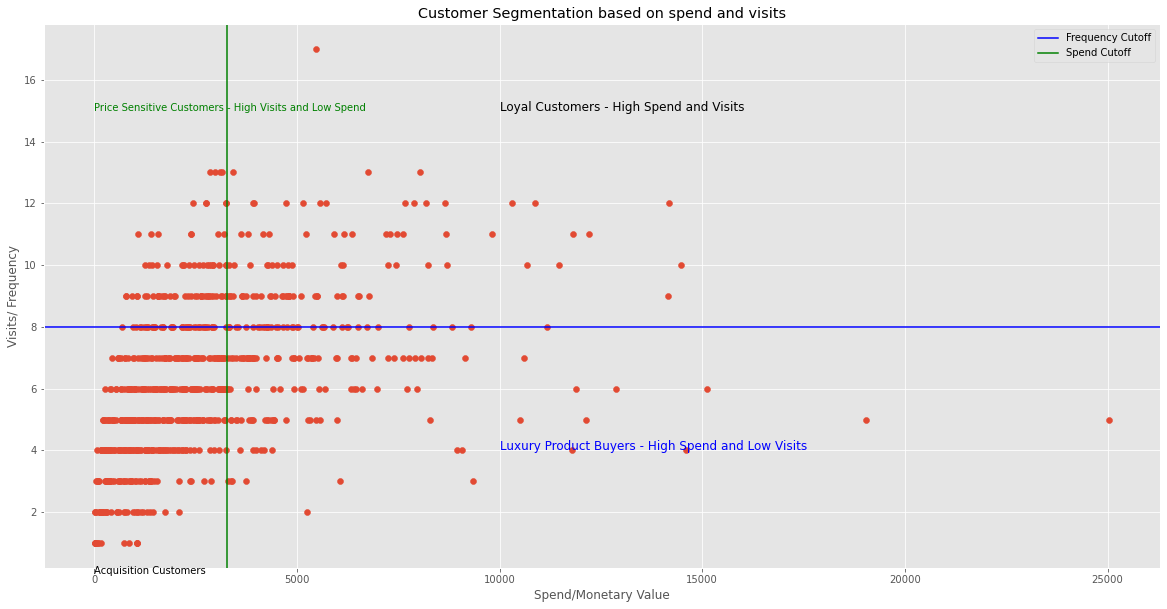

In [29]:
plt.scatter(x = rfmTable['monetary_value'],y = rfmTable['frequency'])
plt.axhline(y = np.quantile(rfmTable['frequency'],0.7),color = 'blue',label = 'Frequency Cutoff')
plt.axvline(x = np.quantile(rfmTable['monetary_value'],0.7),color = 'green',label = 'Spend Cutoff')

plt.text(10000, 15, 'Loyal Customers - High Spend and Visits', fontsize = 12)

plt.text(10000, 4, 'Luxury Product Buyers - High Spend and Low Visits', fontsize = 12,color = 'blue')

plt.text(0, 15, 'Price Sensitive Customers - High Visits and Low Spend', fontsize = 10,color = 'green')

plt.text(0, 0, 'Acquisition Customers', fontsize = 10)


plt.xlabel("Spend/Monetary Value")
plt.ylabel("Visits/ Frequency")
plt.legend()
plt.title("Customer Segmentation based on spend and visits")
plt.show()

# Creating Segments

In [30]:
def frequency_and_value(freq,spend,freq_cutoff,spend_cutoff):
    if freq > freq_cutoff:
        if spend > spend_cutoff:
            return 'Loyal Customers - High Spend and High Visits'
        else:
            return 'Price Sensitive Customers - High Visits and Low Spend'
    else:
        if spend > spend_cutoff:
            return 'Luxury Product Buyers - High Spend and Low Visits'
        else:
            return 'Acquistion Customers'
    
    

In [31]:
spend_cutoff =  np.quantile(rfmTable['monetary_value'],0.7)
freq_cutoff =  np.quantile(rfmTable['frequency'],0.7)
seg_list = []

for index,row in rfmTable.iterrows():
    freq = row['frequency']
    spend = row['monetary_value']
    
    segment = frequency_and_value(freq,spend,freq_cutoff,spend_cutoff)
    seg_list.append(segment)
    
rfmTable['FS_Segment'] = seg_list

In [32]:
rfmTable.head()

,recency,frequency,monetary_value,FS_Segment
customer,,,,
Aaron Bergman,526,3,887,Acquistion Customers
Aaron Hawkins,123,7,1744,Acquistion Customers
Aaron Smayling,199,7,3050,Acquistion Customers
Adam Bellavance,165,8,7756,Luxury Product Buyers - High Spend and Low Visits
Adam Hart,145,10,3249,Price Sensitive Customers - High Visits and Lo...


# QA through Scatter plot

<AxesSubplot:xlabel='monetary_value', ylabel='frequency'>

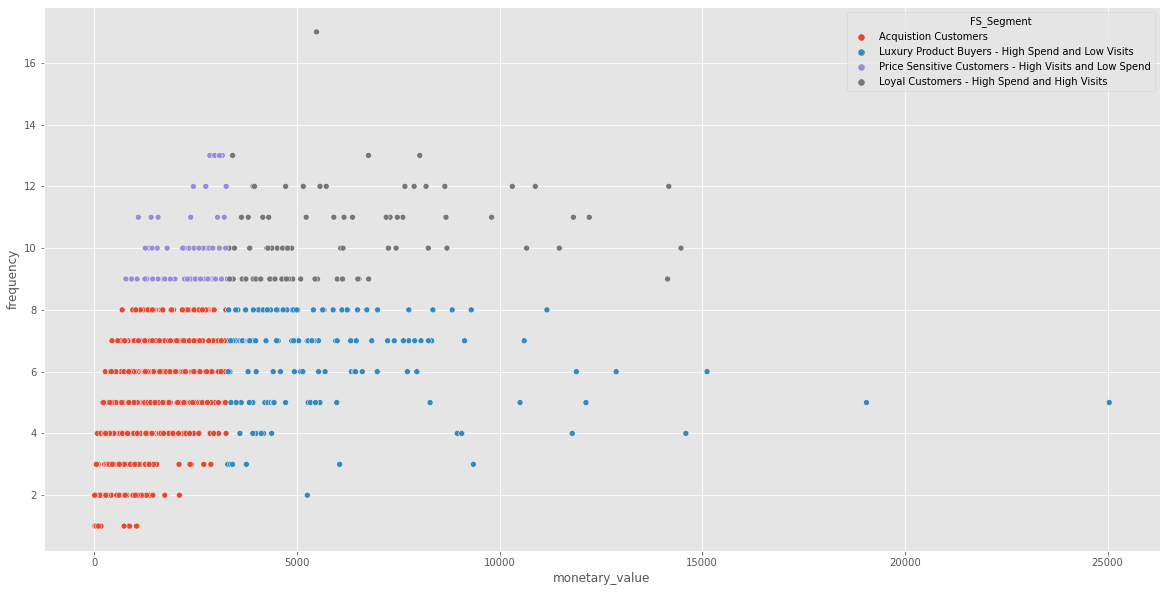

In [33]:
sns.scatterplot(x = 'monetary_value',y = 'frequency',hue = 'FS_Segment',data = rfmTable)

# Recency Analysis

In [34]:
rfmTable['recency'].describe()

count     793.000000
mean      257.805801
std       186.231107
min       111.000000
25%       141.000000
50%       186.000000
75%       294.000000
max      1277.000000
Name: recency, dtype: float64

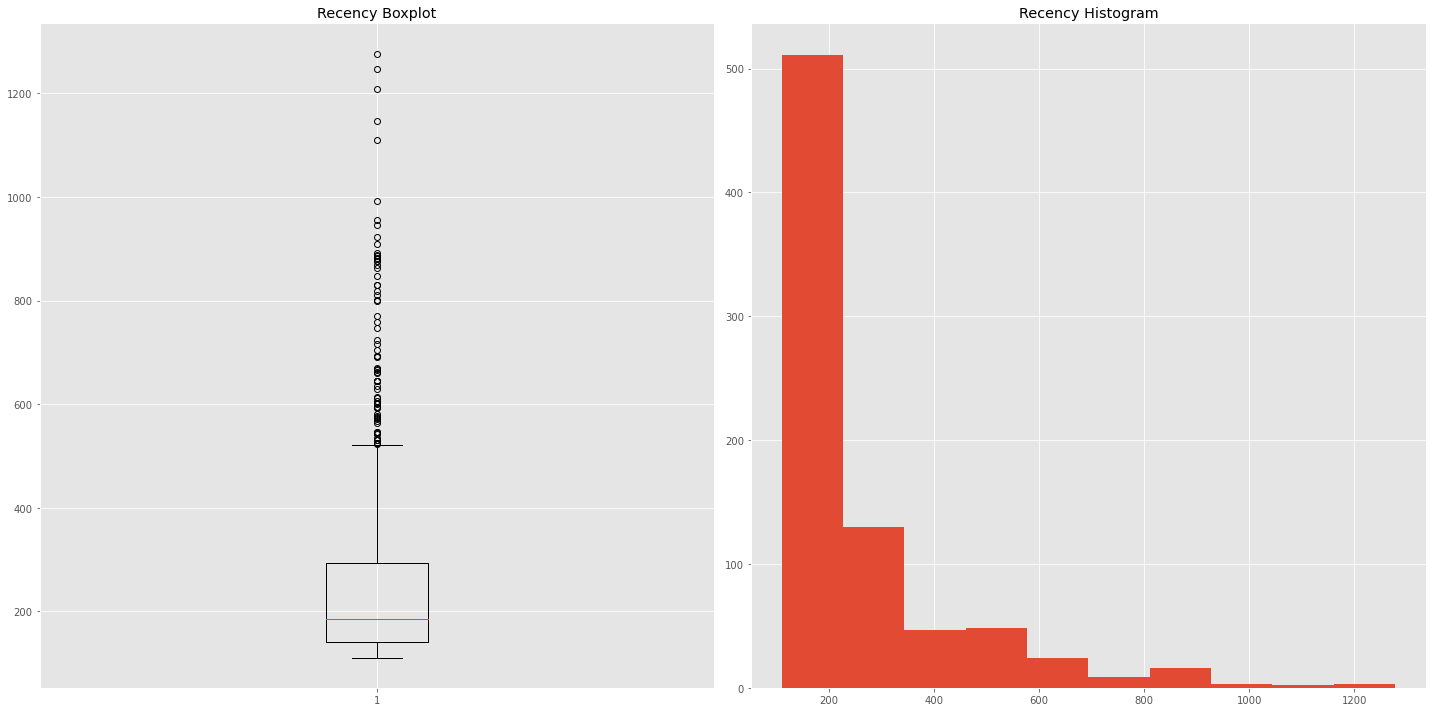

In [39]:
plt.subplot(1,2,1)
plt.boxplot(rfmTable['recency'])
plt.title("Recency Boxplot")

plt.subplot(1,2,2)
plt.hist(rfmTable['recency'])
plt.title("Recency Histogram")

plt.tight_layout()
plt.show()

##  Analysis - A lot of customers have very high recency which means they are potentially lapsed and goneaways, whereas some customers are at the verge of lapsing

# Checking Relationship between Recency vs Frequency

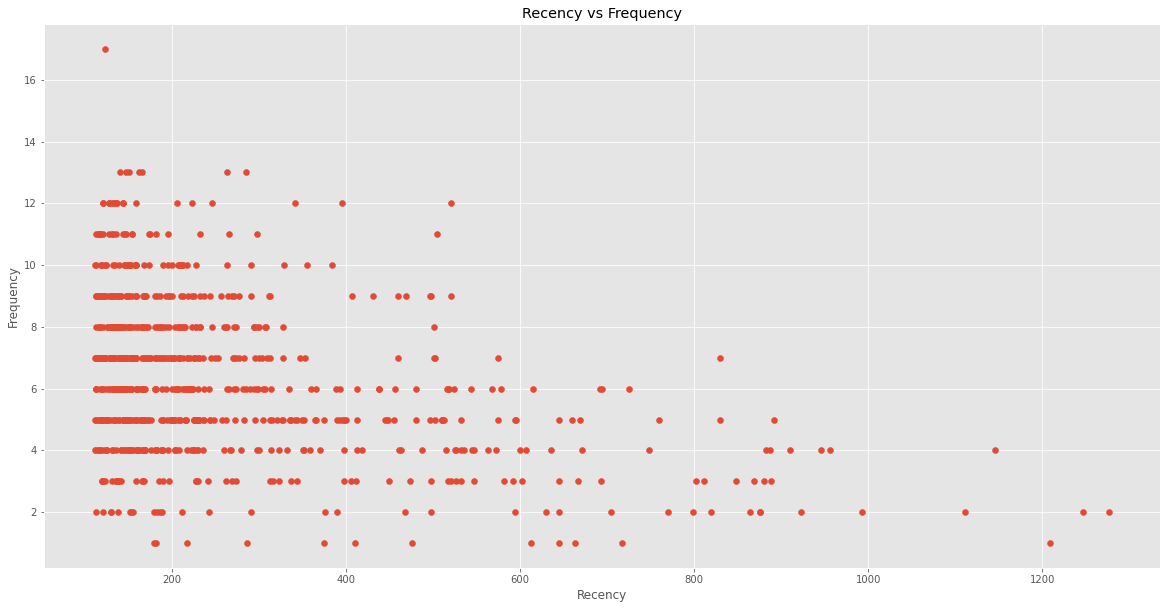

In [43]:
plt.scatter(rfmTable['recency'],rfmTable['frequency'])
plt.title("Recency vs Frequency")
plt.xlabel("Recency")
plt.ylabel("Frequency")
plt.show()

## Customer with Low Recency have high frequency since they visit the store more often 

# Creating recency Overlay

recency greater than average and within 1 std - Potential Lapsing <br>
recency greater than average+1std and within 1 std - Lapsed

In [44]:
mean = np.mean(rfmTable['recency'])
potential_lapsing_cutoff = mean + np.std(rfmTable['recency'])

In [51]:
def recency_function(recency):
    if recency <= mean:
        return 'Non Lapsed'
    elif recency>mean and recency<=potential_lapsing_cutoff:
        return 'Potential_Lapsing'
    else:
        return 'Lapsed'

In [52]:
rfmTable['Recency_Segment'] = rfmTable['recency'].apply(recency_function)

In [53]:
rfmTable.head()

,recency,frequency,monetary_value,FS_Segment,Recency_Segment
customer,,,,,
Aaron Bergman,526,3,887,Acquistion Customers,Lapsed
Aaron Hawkins,123,7,1744,Acquistion Customers,Non Lapsed
Aaron Smayling,199,7,3050,Acquistion Customers,Non Lapsed
Adam Bellavance,165,8,7756,Luxury Product Buyers - High Spend and Low Visits,Non Lapsed
Adam Hart,145,10,3249,Price Sensitive Customers - High Visits and Lo...,Non Lapsed


<AxesSubplot:xlabel='monetary_value', ylabel='frequency'>

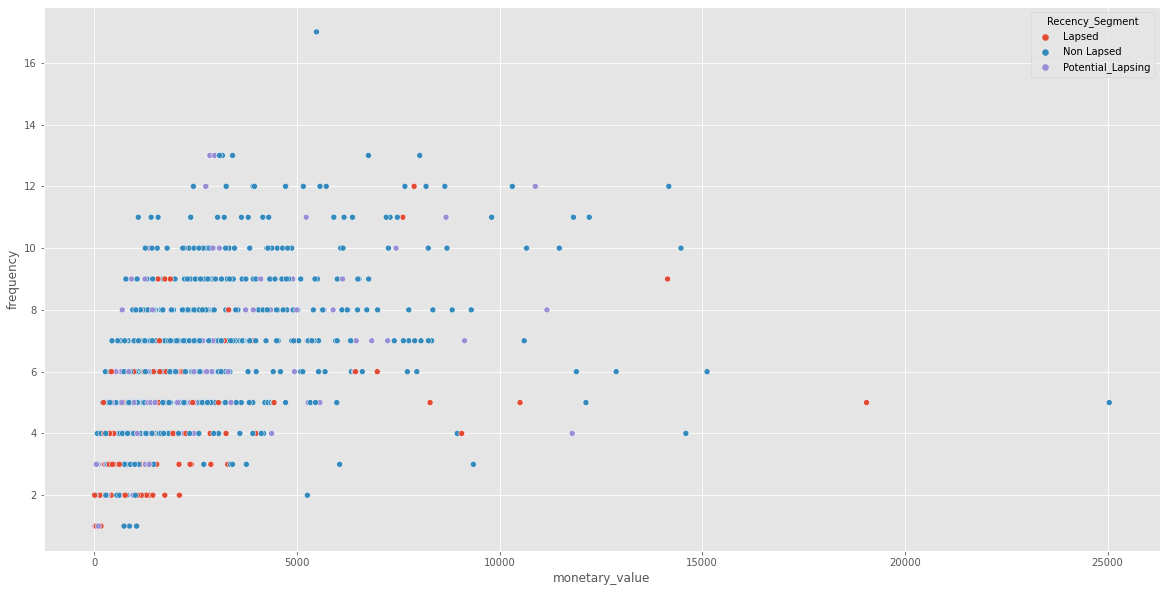

In [54]:
sns.scatterplot(x = 'monetary_value',y = 'frequency',hue = 'Recency_Segment',data = rfmTable)

# A lot of Lapsers present in low spend low visit segment need to reactivate them

# Cross Tab of all segments

In [55]:
cross_data = pd.crosstab(index = rfmTable['FS_Segment'],columns = rfmTable['Recency_Segment'])

In [56]:
cross_data.head()

Recency_Segment,Lapsed,Non Lapsed,Potential_Lapsing
FS_Segment,,,
Acquistion Customers,92,308,80
Loyal Customers - High Spend and High Visits,4,72,8
Luxury Product Buyers - High Spend and Low Visits,14,115,25
Price Sensitive Customers - High Visits and Low Spend,3,60,12


# Potential Marketing Strategy

<ol>
    <li> <b> Acquisition Customers - </b> - Majority of the customers have lapsed hence we need to reactivate them and increase their spend and visits they can be offered high discount coupons, potentially reactivate them.
     <li> <b> Loyal Customers - </b> -These customers like shopping with us quite regularly without lapsing as lapsers are comparitively low , hence we can increase their loyalty by enrolling them in long term loyalty programmes </li>
     <li> <b> Luxury Product Buyers </b> - Thse customers have a spent a good amount with us without visiting that often they can be targeted to visit the store more often or with luxury products , trade drivers etc
       <li> <b> Price Sensitive Customers </b> - These customers visit the store often but don't spend that much hence can be targeted with high discount cheap products
         
         